# Predecir si el ejercicio es correcto
Aplicar Machine Learning para predecir si el paciente está realizando correctamente el ejercicio (clasificación binaria)

In [64]:
# ---------- importar librerías---------
# Manipular los datos
import pandas as pd

# Gráficas
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
sns.set_theme(style="darkgrid")

# scikit-learn (ML en python)
## Procesar el dataset
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import LeaveOneGroupOut
# or LeavePGroupsOut
## Modelos ML
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
## Evaluación de los modelos
from sklearn.metrics import *
from sklearn.model_selection import cross_val_score
## Hiperparametrizacion
from sklearn.model_selection import RandomizedSearchCV

# Class imbalance
from imblearn.under_sampling import NearMiss, EditedNearestNeighbours
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.combine import SMOTETomek, SMOTEENN
from collections import Counter

## Seleccion de variables
from sklearn.decomposition import PCA

# Pipeline
from imblearn.pipeline import Pipeline


# Para ignorar los Warnings
import warnings
from sklearn.exceptions import FitFailedWarning 

warnings.simplefilter(action = 'ignore', category = FutureWarning)
warnings.simplefilter(action = 'ignore', category = UserWarning)

In [65]:
#---------Importar los datos-----------
# Dataframe medidas calculadas por repetición
df = pd.read_csv('../csvFiles/medidasPerRepetition.csv', dtype=object)

In [66]:
# ------Preparar el dataset-------
encoder = OrdinalEncoder(categories=[list(set(df["Position"].values))])
encoder.fit(df[["Position"]])
df["Position"] = encoder.transform(df[["Position"]])

# pasar variable obj to numeric
df = df.apply(pd.to_numeric, errors='ignore')

# cmabiar las poorly executed to incorrectly executed
df[df['CorrectLabel']==3] = 2

In [67]:
df

,SubjectID,GestureLabel,RepetitionNumber,CorrectLabel,Position,Duration,HipAngleLeft_standardDeviation,RightArmAngle_standardDeviation,KneeAngleLeft_standardDeviation,AnkleAngleLeft_standardDeviation,...,ElbowAngleRight_Kurtosis,LeftArmAngle_Kurtosis,ShoulderAngleRight_Kurtosis,WristAngleLeft_Kurtosis,ElbowAngleLeft_Kurtosis,WristAngleRight_Kurtosis,ShoulderAngleLeft_Kurtosis,HipAngleRight_Kurtosis,ArmsTogetherAngle_Kurtosis,AnkleAngleRight_Kurtosis
0,101,0,1,1,4.0,59,0.360868,2.765557,0.208706,0.658147,...,-1.509605,0.537440,0.247256,-1.154852,-0.917690,0.198533,-0.635142,-0.924047,-0.604303,-0.404407
1,101,0,2,1,4.0,44,0.118578,2.298280,0.221489,0.831351,...,-1.280617,0.726806,-1.751783,-0.770170,0.418772,1.048145,-0.903003,-0.198608,0.893421,-0.276498
2,101,0,3,1,4.0,53,0.246191,3.445304,0.200163,0.960267,...,-1.455247,0.140506,0.719889,-0.580654,-0.761280,-0.393123,0.412761,-1.007602,-0.413869,-0.530532
3,101,0,4,1,4.0,57,0.283214,3.626022,0.344905,0.573168,...,-1.514596,1.060234,0.495865,-0.136403,-0.584491,-0.610934,-1.330692,-1.487544,-1.258808,-0.057357
4,101,0,5,1,4.0,60,0.393636,3.767307,0.217658,0.658998,...,-1.360146,-1.527706,0.393907,-0.426884,-0.534952,-1.170145,-0.844501,-1.427344,-0.338747,-0.322273
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2584,307,8,8,1,4.0,48,8.563372,1.555034,6.503301,10.353342,...,0.234936,-0.781945,0.465005,-0.949755,-0.872651,0.056064,-0.971195,-1.014746,-0.339300,-0.270964
2585,307,8,9,1,4.0,48,7.609432,1.332626,6.647659,4.728600,...,-0.759991,-1.644095,-0.019000,0.520658,-1.114747,-1.006323,-0.963412,-1.651462,-0.863515,-1.671159
2586,307,8,10,1,4.0,47,6.656025,1.315829,5.285898,8.033854,...,-0.707586,-0.826005,-1.203659,-0.834273,-0.267076,-0.776532,0.037584,-1.103517,-0.449516,-2.061997
2587,307,8,11,1,4.0,51,7.627692,1.896625,6.237513,9.185235,...,-0.899253,-0.620023,-0.087088,-0.261026,-0.983178,-0.052683,-0.660478,-1.697380,-0.445218,-1.011064


## ML simple

In [68]:
#-------Funciones--------

# Para entrenar los modelos de ML
def aplicar_modelos(X: pd.DataFrame, y: pd.DataFrame, file):
    """
    Aplica una lista de modelos de aprendizaje automático a los datos de prueba y muestra
    los informes de evaluación.

    Parámetros:
    * X: datos de entrenamiento.
    * y: target de entrenamiento.
    * file: archivo para escribir los resultados.
    """
    # creación de los modelos
    knn = KNeighborsClassifier()  # K-Neighbors classifier
    dtree = DecisionTreeClassifier()  # Decision tree
    nb = GaussianNB()  # Naive Bayes
    svm = SVC()  # Support Vector Machine
    rf = RandomForestClassifier()  # Random Forest
    lr = LogisticRegression()  # Logistic Regression

    models = [knn, dtree, nb, svm, rf, lr]
    logo = LeaveOneGroupOut()
    grupos = X['SubjectID']

    # Iteramos sobre los modelos
    for modelo in models:
        try:
            accuracy_scores = cross_val_score(modelo, X, y, groups=grupos, cv=logo, scoring='accuracy')
            recall_scores = cross_val_score(modelo, X, y, groups=grupos, cv=logo, scoring='recall')
            file.write(f"\n\t Modelo: {modelo.__class__.__name__}\n")
            file.write("\t%0.2f accuracy with a standard deviation of %0.2f\n" % (accuracy_scores.mean(), accuracy_scores.std()))
            file.write("\t%0.2f recall with a standard deviation of %0.2f\n" % (recall_scores.mean(), recall_scores.std()))            
        except ValueError as e:
            file.write(f"Skipping {modelo.__class__.__name__} due to ERROR: {e}\n")

# Aplicar imbalance learn
def aplicar_imblearn(X, y, file):
    nm1 = NearMiss(version=1, n_neighbors=2)
    enn = EditedNearestNeighbours()
    adasyn = ADASYN(n_neighbors=2)
    smote = SMOTE(k_neighbors=2)
    smotetomek = SMOTETomek(smote=smote)
    smote_enn = SMOTEENN(smote=smote)

    imblearns = [nm1, enn, adasyn, smote, smotetomek, smote_enn]
    for imblearn in imblearns:
        try:
            X_im, y_im = imblearn.fit_resample(X, y)
            file.write(f"\n- MODELO DE RESAMPLING: {imblearn.__class__.__name__}\n")
            file.write("Distribution of class labels before resampling {}\n".format(Counter(y)))
            file.write("Distribution of class labels after resampling {}\n".format(Counter(y_im)))
            aplicar_modelos(X_im, y_im, file)
        except ValueError as e:
            file.write(f"Skipping {imblearn.__class__.__name__} due to ERROR: {e}\n")
        except RuntimeError as e:
            file.write(f"Skipping {imblearn.__class__.__name__} due to ERROR: {e}\n")

# dividir en test y train df_gestures
def split_df_gestures(df, target):
    test_df = df.loc[(df.SubjectID==101) | (df.SubjectID==105) | (df.SubjectID==201) | (df.SubjectID==202) | (df.SubjectID==301) | (df.SubjectID==302)]
    train_df = df.loc[(df.SubjectID!=101) & (df.SubjectID!=105) & (df.SubjectID!=201) & (df.SubjectID!=202) & (df.SubjectID!=301) & (df.SubjectID!=302)] 

    X_train = train_df.drop([target], axis=1)
    y_train=pd.DataFrame(train_df[target]) 
    X_test= test_df.drop([target], axis=1) 
    y_test =pd.DataFrame(test_df[target])

    # # Convertimos los df de target (y) a 1-d
    y_train = y_train.values.ravel()
    y_test = y_test.values.ravel()

    return X_train, X_test, y_train, y_test

In [69]:
gestures = df['GestureLabel'].unique()

# with open('cvResults.txt', 'w') as file:
#     for gesture in gestures:
#         df_gesture = df[df['GestureLabel'] == gesture]
#         #---------Dividimos en train y test------------
#         X_train, X_test, y_train, y_test = split_df_gestures(df_gesture, 'CorrectLabel')  

#         file.write(f'\n------------ CLASIFICACION GESTO {gesture} -----------\n')
#         aplicar_imblearn(X_train, y_train, file)

El mejor es SMOTEtomek

C:\Users\nerea\AppData\Local\Temp\ipykernel_16116\1144418498.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  balanced_data['CorrectLabel'] = y_resampled


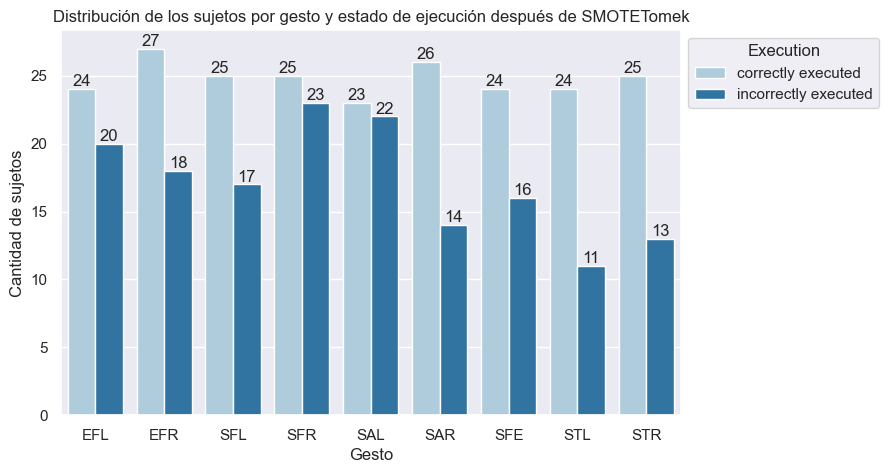

In [70]:
smotetomek = SMOTETomek(smote=SMOTE(k_neighbors=2))
X= df.drop(['CorrectLabel'], axis=1) 
y =pd.DataFrame(df['CorrectLabel'])
X_resampled, y_resampled = smotetomek.fit_resample(X, y)

# Combine the resampled features with the original SubjectID and GestureLabel
balanced_data = pd.DataFrame(X_resampled, columns=X.columns)
balanced_data['CorrectLabel'] = y_resampled

# Calculate the subject counts per gesture and execution status
subject_count_per_gesture_correct = balanced_data.groupby(["GestureLabel", "CorrectLabel"])["SubjectID"].nunique().reset_index()

# Plotting
plt.figure(figsize=(8, 5))
ax = sns.barplot(x="GestureLabel", y="SubjectID", hue="CorrectLabel",
                 data=subject_count_per_gesture_correct, palette="Paired")
# flare, Paired
ax.set_title("Distribución de los sujetos por gesto y estado de ejecución después de SMOTETomek")
ax.set_xlabel("Gesto")
ax.set_ylabel("Cantidad de sujetos")

# Set the x-axis ticks to the desired labels
gesture_labels = ['EFL', 'EFR', 'SFL', 'SFR', 'SAL', 'SAR', 'SFE', 'STL', 'STR']
ax.set_xticklabels(gesture_labels)

# Modify the legend labels
legend_labels = ['correctly executed', 'incorrectly executed', 'poorly executed']
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=legend_labels, title='Execution')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

for i in ax.containers:
    ax.bar_label(i,)

plt.show()

## Pipeline con hiperparametrizacion y feature selection

In [71]:
# Para ignorar los FitFileWarning
warnings.filterwarnings("ignore", category=FitFailedWarning)

# definimos el param_grid
param_grid = [
    {
        'balance_data__smote__k_neighbors': [2, 3, 4],
        'reduce_dim__n_components': [0.5, 0.7, 0.8, 0.90, 1],
        'classifier': [KNeighborsClassifier()],
        'classifier__n_neighbors': [2, 3, 5], 
        'classifier__weights': ['uniform', 'distance'], 
        'classifier__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']  
    },
    {
        'balance_data__smote__k_neighbors': [2, 3, 4],
        'reduce_dim__n_components': [0.5, 0.7, 0.8, 0.90, 1],
        'classifier': [DecisionTreeClassifier()],
        'classifier__criterion': ['gini', 'entropy'],
        'classifier__max_depth': [None, 10, 20, 30]
    },
    {
        'balance_data__smote__k_neighbors': [2, 3, 4],
        'reduce_dim__n_components': [0.5, 0.7, 0.8, 0.90, 1],
        'classifier': [GaussianNB()]
    },
    {
        'balance_data__smote__k_neighbors': [2, 3, 4],
        'reduce_dim__n_components': [0.5, 0.7, 0.8, 0.90, 1],
        'classifier': [SVC()],
        'classifier__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
        'classifier__C': [0.1, 1, 10, 100]
    },
    {
        'balance_data__smote__k_neighbors': [2, 3, 4],
        'reduce_dim__n_components': [0.5, 0.7, 0.8, 0.90, 1],
        'classifier': [RandomForestClassifier()],
        'classifier__n_estimators': [50, 100, 200],
        'classifier__max_features': ['auto', 'sqrt', 'log2']
    },
    {
        'balance_data__smote__k_neighbors': [2, 3, 4],
        'reduce_dim__n_components': [0.5, 0.7, 0.8, 0.90, 1],
        'classifier': [LogisticRegression(max_iter=500)],
        'classifier__C': [0.01, 0.1, 1, 10, 100]
    }
]

logo = LeaveOneGroupOut()

for gesture in gestures:

    df_gesture = df[df['GestureLabel'] == gesture]

    #---------Dividimos en train y test------------
    X_train, X_test, y_train, y_test = split_df_gestures(df_gesture, 'CorrectLabel')   
    
    print(f'\n------------ CLASIFICACION GESTO {gesture} -----------\n')
    pipeline = Pipeline([('balance_data',  SMOTETomek(smote=SMOTE(k_neighbors=2))),
                        ('reduce_dim', PCA()),
                        ('classifier', KNeighborsClassifier(n_neighbors=2))])


    random = RandomizedSearchCV(pipeline, param_grid, cv=logo, n_jobs=-1)
    random.fit(X_train, y_train, groups=X_train['SubjectID'])
    best_pipeline = random.best_estimator_

    print('Training set score: ' + str(best_pipeline.score(X_train, y_train)))
    print('Test set score: ' + str(best_pipeline.score(X_test, y_test)))
    print(best_pipeline)

    globals()[f'pipeline_{gesture}'] = best_pipeline




------------ CLASIFICACION GESTO 0 -----------

Training set score: 0.975
Test set score: 0.9137931034482759
Pipeline(steps=[('balance_data', SMOTETomek(smote=SMOTE(k_neighbors=3))),
                ('reduce_dim', PCA(n_components=1)),
                ('classifier',
                 KNeighborsClassifier(algorithm='kd_tree', n_neighbors=2))])

------------ CLASIFICACION GESTO 1 -----------

Training set score: 0.9154929577464789
Test set score: 0.9090909090909091
Pipeline(steps=[('balance_data', SMOTETomek(smote=SMOTE(k_neighbors=4))),
                ('reduce_dim', PCA(n_components=0.7)),
                ('classifier', SVC(C=100, kernel='poly'))])

------------ CLASIFICACION GESTO 2 -----------

Training set score: 0.9897610921501706
Test set score: 0.9361702127659575
Pipeline(steps=[('balance_data', SMOTETomek(smote=SMOTE(k_neighbors=2))),
                ('reduce_dim', PCA(n_components=0.8)),
                ('classifier', RandomForestClassifier(n_estimators=200))])

------------ CL

In [ ]:
pipeline_2.get_params().keys()
